In [3]:
import numpy as np
import pandas as pd

import pandas_datareader as pdr
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
sns.set_style('darkgrid')

## Gather Data

In [6]:
# get a list of stocks
ticker_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
stocks_df = ticker_df[0]

stocks_df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [7]:
# Different sectors
sectors = set(stocks_df['GICS Sector'])
sectors

{'Communication Services',
 'Consumer Discretionary',
 'Consumer Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities'}

In [8]:
start = datetime(2019, 12, 1)
end = datetime.today()

def get_stocks(name):
    stock = pdr.get_data_yahoo(symbols=name, start=start, end=end)
    return stock

tickers = [tick for tick in stocks_df['Symbol']]

stock_dict = {}

for tick in tickers:
    try:
        stock_dict[tick] = get_stocks(tick)
    except:
        print('Exception occured for -  ', tick)

Exception occured for -   BRK.B
Exception occured for -   BF.B


## Calculating Returns

In [9]:
returns = pd.DataFrame()

for key in stock_dict.keys():
    returns[key + ' Return'] = stock_dict[key]['Adj Close'].pct_change()
    
returns.head()

,MMM Return,ABT Return,ABBV Return,ABMD Return,ACN Return,ATVI Return,ADBE Return,AMD Return,AAP Return,AES Return,...,WYNN Return,XEL Return,XRX Return,XLNX Return,XYL Return,YUM Return,ZBRA Return,ZBH Return,ZION Return,ZTS Return
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-03,-0.018423,-0.001775,-0.012410,-0.005567,-0.004209,0.006638,0.003832,0.004389,-0.025168,-0.004228,...,-0.023369,0.004248,-0.006493,-0.017946,-0.013194,-0.011038,-0.001238,-0.007338,-0.018788,0.005170
2019-12-04,0.011927,0.009720,0.014543,0.014334,0.004176,-0.013006,-0.004607,0.020308,-0.001835,0.003185,...,0.018353,0.008949,0.002614,0.017146,-0.002118,-0.002514,0.012395,0.034658,0.011118,-0.006554
2019-12-05,-0.016573,0.000704,-0.005505,-0.024859,0.001353,0.020601,0.001719,-0.001764,-0.000263,-0.004762,...,-0.003958,0.002096,-0.013820,0.005545,-0.006235,-0.006855,-0.006279,-0.005055,0.003869,0.003090
2019-12-06,0.043195,0.002816,0.002998,0.000793,0.013510,0.004001,0.010560,0.000252,0.015300,-0.004785,...,0.028832,-0.002253,-0.001322,0.013125,0.005473,0.002538,0.021064,0.006165,0.008316,0.013404


## Calculating Discount

In [12]:
# stocks at the biggest discount

discount_dict = {}

def calculate_discount(df):
    max_price = df['Adj Close'].describe()['75%']
    min_price = df['Adj Close'].min()
    return (max_price - min_price)/max_price
    

for tick in stock_dict.keys():
    discount_dict[tick] = calculate_discount(stock_dict[tick])
    
discount_dict['GOOG']

0.26883072697497745

## Quantifying Risk and Sector Wise analysis

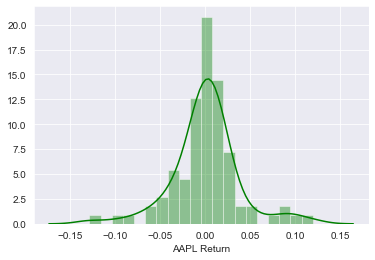

In [13]:
sns.distplot(returns['AAPL Return'],color='green',bins=20)

In [17]:
def get_sector(stock):
    return [x for x in stocks_df[stocks_df['Symbol'] == stock]['GICS Sector']]

stock_info_df = pd.DataFrame.from_dict(discount_dict, orient='index').reset_index()
stock_info_df.columns = ['ticker', 'discount']
stock_info_df['sector'] = [get_sector(tick)[0] for tick in stock_info_df['ticker']]

# add name of the ticker too
def get_stockname(ticker):
    return [x for x in stocks_df[stocks_df['Symbol'] == ticker]['Security']][0]

std_list = []

for tick in stock_info_df['ticker']:
    std_list.append(returns[tick + ' Return'].std()) # risk metric
    
stock_info_df['risk'] = std_list
    
current_price = [stock_dict[tick]['Adj Close'].iloc[-1] for tick in stock_info_df['ticker']]
stock_info_df['current_price'] = current_price
stock_info_df.head()

,ticker,discount,sector,risk,current_price
0,MMM,0.322545,Industrials,0.031717,147.779999
1,ABT,0.281503,Health Care,0.032930,86.040001
2,ABBV,0.271819,Health Care,0.029195,79.750000
3,ABMD,0.280729,Health Care,0.033420,160.080002
4,ACN,0.313777,Information Technology,0.035162,177.919998


In [18]:
stock_info_df.groupby('sector').describe()['discount']

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,26.0,0.352442,0.141240,0.133648,0.269130,0.357465,0.448570,0.712540
Consumer Discretionary,64.0,0.517588,0.162161,0.138539,0.422770,0.514539,0.602859,0.861504
Consumer Staples,32.0,0.281843,0.145838,0.094047,0.162223,0.260596,0.346900,0.668773
Energy,27.0,0.631353,0.184962,0.000000,0.574200,0.638630,0.761554,0.864545
Financials,65.0,0.454041,0.115841,0.167214,0.373942,0.447546,0.540549,0.711788
Health Care,60.0,0.303749,0.111041,0.000000,0.246497,0.294643,0.377532,0.537212
Industrials,71.0,0.406337,0.141952,0.000000,0.322829,0.411988,0.470398,0.801929
Information Technology,71.0,0.341480,0.121127,0.000000,0.276462,0.314009,0.388795,0.793543
Materials,28.0,0.425977,0.121474,0.170204,0.311369,0.438235,0.509449,0.660764


In [19]:
stock_info_df.groupby('sector').describe()['risk']

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
Communication Services,26.0,0.036978,0.008683,0.021883,0.031228,0.034434,0.038068,0.058819
Consumer Discretionary,64.0,0.050407,0.015854,0.019957,0.040505,0.046468,0.057677,0.097467
Consumer Staples,32.0,0.033629,0.009819,0.025344,0.027485,0.031193,0.035072,0.073964
Energy,26.0,0.063760,0.014861,0.037179,0.054033,0.059558,0.073029,0.103081
Financials,65.0,0.046968,0.009188,0.031279,0.040285,0.044941,0.053163,0.077099
Health Care,58.0,0.035284,0.007394,0.018335,0.030664,0.033523,0.038441,0.057067
Industrials,70.0,0.042108,0.012245,0.022722,0.034543,0.038305,0.045745,0.091622
Information Technology,70.0,0.041340,0.009020,0.024191,0.036422,0.039557,0.044864,0.082160
Materials,28.0,0.043761,0.007518,0.032968,0.038401,0.042353,0.046811,0.064655


## Top 5 by Sector

In [20]:
def top5_sector(sector, metric, asc = False):
    cols = ['ticker', 'discount', 'risk', 'current_price']
    return stock_info_df[stock_info_df['sector'] == sector][cols].sort_values(by = metric, ascending = asc).head(5)

In [21]:
top5_sector('Communication Services', 'risk', True)

,ticker,discount,risk,current_price
470,VZ,0.170309,0.021883,57.439999
166,EA,0.203646,0.029186,105.800003
100,CHTR,0.271201,0.030137,466.640015
25,GOOG,0.268831,0.030630,1211.449951
5,ATVI,0.138566,0.030769,60.459999


In [22]:
top5_sector('Information Technology', 'discount', False)

,ticker,discount,risk,current_price
21,ADS,0.793543,0.077241,38.580002
158,DXC,0.741461,0.082160,16.090000
486,WDC,0.569913,0.054085,45.049999
495,XRX,0.568576,0.047087,19.360001
194,FLIR,0.525035,0.045688,34.500000
